Images loaded successfully.


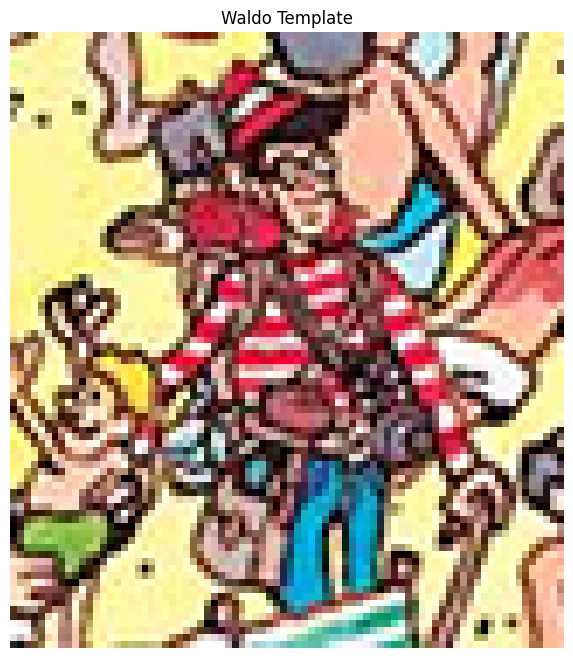

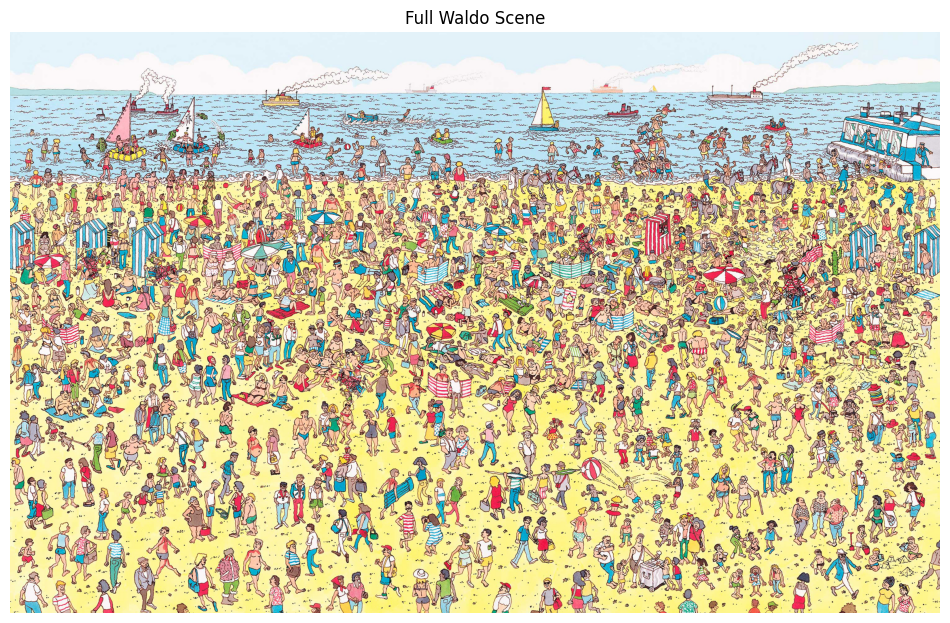

In [2]:
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import os

# Ensure the images are in the same directory as the notebook or provide the full path
# For demonstration, assuming they are in a 'waldo_images' subfolder or current directory
image_dir = 'waldo/' # Or specify the path if different, e.g., 'waldo_images/'

# Load images
try:
    template_path = os.path.join(image_dir, 'template.png')
    waldo_image_path = os.path.join(image_dir, 'waldo.png')
    
    template = cv2.imread(template_path)
    waldo_full_image = cv2.imread(waldo_image_path)

    if template is None:
        raise FileNotFoundError(f"Template image not found at {template_path}")
    if waldo_full_image is None:
        raise FileNotFoundError(f"Waldo full image not found at {waldo_image_path}")

    template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    waldo_full_image_gray = cv2.cvtColor(waldo_full_image, cv2.COLOR_BGR2GRAY)

except FileNotFoundError as e:
    print(e)
    print("Please make sure 'template.png' and 'waldo.jpg' are in the specified directory.")
    # Exit or handle error gracefully
    exit()

# Function to display images
def show_image(img, title="Image", cmap=None):
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB) if len(img.shape) == 3 else img, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

print("Images loaded successfully.")
show_image(template, "Waldo Template")
show_image(waldo_full_image, "Full Waldo Scene")

Starting Part A: Baseline Method (Template Matching)
Part A: Processing time = 8.85 seconds
Part A: Found 4 potential Waldos.


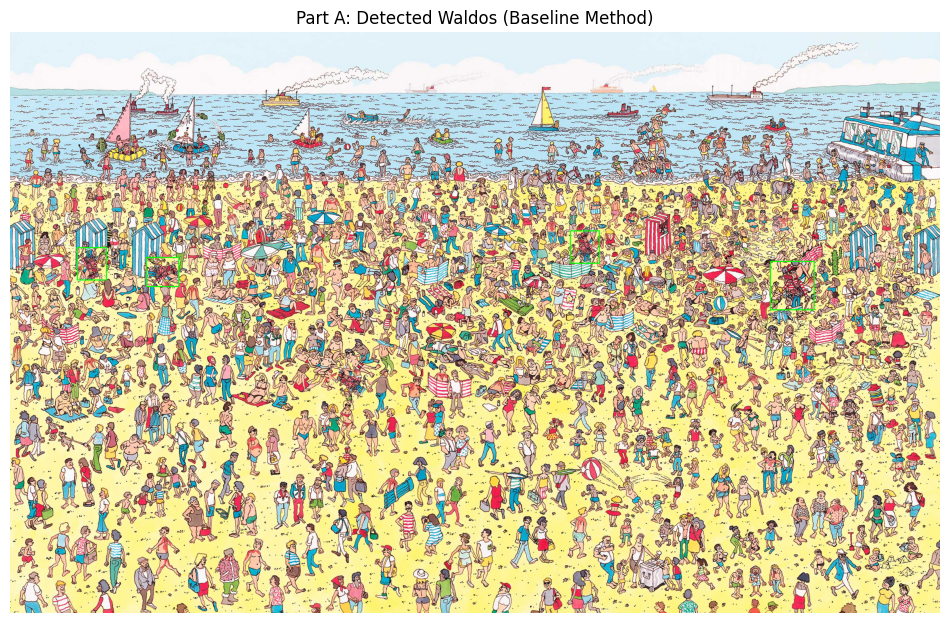

In [3]:
# Part A: Baseline Method (Template Matching with Multi-Scale and Multi-Rotation)

print("Starting Part A: Baseline Method (Template Matching)")

start_time_a = time.time()

# Store detection results: (top_left_x, top_left_y, width, height, score)
detected_waldos = []

# Define scales and rotations to check
scales = [i / 10.0 for i in range(8, 19)] # From 0.8x to 1.8x
rotations = [0, 45, 90, 135, 180, 225, 270, 315]

# Get template dimensions
h_template, w_template = template_gray.shape

for scale in scales:
    # Resize template
    resized_template = cv2.resize(template_gray, (int(w_template * scale), int(h_template * scale)))
    

    for angle in rotations:
        # Rotate the template
        # Get rotation matrix
        (h_res, w_res) = resized_template.shape[:2]
        center = (w_res // 2, h_res // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        
        # Determine new dimensions for rotated image to avoid cropping
        cos = np.abs(M[0, 0])
        sin = np.abs(M[0, 1])
        nW = int((h_res * sin) + (w_res * cos))
        nH = int((h_res * cos) + (w_res * sin))
        
        # Adjust the rotation matrix to take into account translation
        M[0, 2] += (nW / 2) - center[0]
        M[1, 2] += (nH / 2) - center[1]
        
        rotated_template = cv2.warpAffine(resized_template, M, (nW, nH), borderValue=(0,0,0)) # black borders

        # Perform template matching
        res = cv2.matchTemplate(waldo_full_image_gray, rotated_template, cv2.TM_CCOEFF_NORMED)
        
        # Define a threshold for detection
        threshold = 0.6 # This threshold might need tuning
        loc = np.where(res >= threshold)
        
        for pt in zip(*loc[::-1]): # Iterate over found locations
            detected_waldos.append((pt[0], pt[1], rotated_template.shape[1], rotated_template.shape[0], res[pt[1], pt[0]]))

end_time_a = time.time()
processing_time_a = end_time_a - start_time_a

# Apply Non-Maximum Suppression (NMS) to the detections
def non_max_suppression_fast(boxes, overlapThresh):
    if len(boxes) == 0:
        return []

    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    pick = []
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 0] + boxes[:, 2] # x + width
    y2 = boxes[:, 1] + boxes[:, 3] # y + height
    scores = boxes[:, 4]

    # Sort by score
    idxs = np.argsort(scores)[::-1]

    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # Correct calculation of overlap (Intersection over Union - IoU)
        intersection_area = w * h
        boxA_area = (x2[i] - x1[i] + 1) * (y2[i] - y1[i] + 1)
        boxB_area = (x2[idxs[:last]] - x1[idxs[:last]] + 1) * (y2[idxs[:last]] - y1[idxs[:last]] + 1)
        
        overlap = intersection_area / (boxA_area + boxB_area - intersection_area)

        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))
    
    return boxes[pick].astype("int")

# Convert detected_waldos to a numpy array for NMS
if detected_waldos:
    detected_waldos_np = np.array(detected_waldos)
    # NMS with a high overlap threshold initially to remove exact duplicates due to overlapping search windows
    # Then a lower threshold to remove closely overlapping detections
    nms_overlap_threshold = 0.4 # Adjust this as needed
    filtered_waldos = non_max_suppression_fast(detected_waldos_np, nms_overlap_threshold)
else:
    filtered_waldos = []

# Draw rectangles on the original image
result_image_a = waldo_full_image.copy()
for (x, y, w, h, score) in filtered_waldos:
    cv2.rectangle(result_image_a, (x, y), (x + w, y + h), (0, 255, 0), 2) # Green rectangle

print(f"Part A: Processing time = {processing_time_a:.2f} seconds")
print(f"Part A: Found {len(filtered_waldos)} potential Waldos.")
show_image(result_image_a, "Part A: Detected Waldos (Baseline Method)")


Starting Part B: Speed-up with downsampling and NMS (no clustering)
Part B: Processing time = 1.21 seconds
Part B: Found 3 Waldos


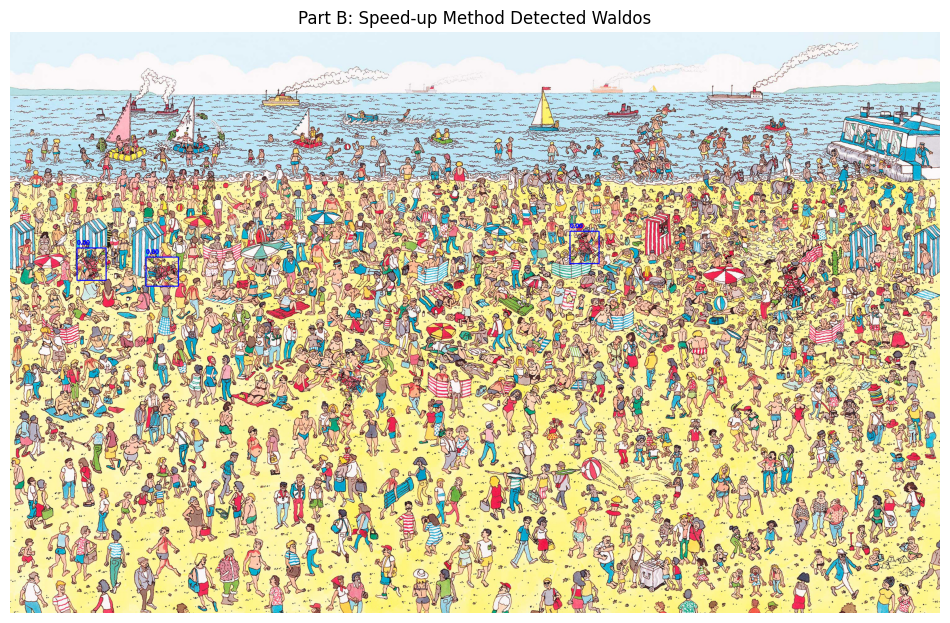

In [15]:


# --- robust NMS (expects boxes as [x, y, w, h, score]) ---
def non_max_suppression(boxes, overlapThresh):
    boxes = np.array(boxes)
    if boxes.size == 0:
        return np.empty((0, 5), dtype=int)

    # If single box flattened to 1D, reshape
    if boxes.ndim == 1:
        boxes = boxes.reshape(1, -1)

    # If boxes provided as (x,y,w,h) without scores, add dummy scores
    if boxes.shape[1] == 4:
        scores = np.ones((boxes.shape[0], 1), dtype=float)
        boxes = np.hstack((boxes.astype(float), scores))
    elif boxes.shape[1] == 5:
        boxes = boxes.astype(float)
    else:
        raise ValueError("boxes must have shape (N,4) or (N,5)")

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    w  = boxes[:, 2]
    h  = boxes[:, 3]
    x2 = x1 + w
    y2 = y1 + h
    scores = boxes[:, 4]

    idxs = np.argsort(scores)[::-1]  # sort by score desc
    pick = []

    while idxs.size > 0:
        i = idxs[0]
        pick.append(i)

        if idxs.size == 1:
            break

        rest = idxs[1:]
        xx1 = np.maximum(x1[i], x1[rest])
        yy1 = np.maximum(y1[i], y1[rest])
        xx2 = np.minimum(x2[i], x2[rest])
        yy2 = np.minimum(y2[i], y2[rest])

        inter_w = np.maximum(0.0, xx2 - xx1)
        inter_h = np.maximum(0.0, yy2 - yy1)
        inter_area = inter_w * inter_h

        area_i = w[i] * h[i]
        area_rest = w[rest] * h[rest]
        union = area_i + area_rest - inter_area

        # avoid division by zero
        iou = inter_area / (union + 1e-8)

        # drop boxes with IoU > threshold
        drop_idxs = np.where(iou > overlapThresh)[0] + 1  # +1 because rest starts at index 1
        idxs = np.delete(idxs, np.concatenate(([0], drop_idxs)))

    return boxes[pick].astype(int)


# ======= Part B: Speed-up with downsampling + NMS (no clustering) =======
print("\nStarting Part B: Speed-up with downsampling and NMS (no clustering)")
start_time_b = time.time()

scale_down = 0.7
waldo_small = cv2.resize(waldo_full_image_gray, (0, 0), fx=scale_down, fy=scale_down)
template_small = cv2.resize(template_gray, (0, 0), fx=scale_down, fy=scale_down)

# rough matching
res = cv2.matchTemplate(waldo_small, template_small, cv2.TM_CCOEFF_NORMED)
threshold = 0.2
loc = np.where(res >= threshold)

# convert to boxes (small scale)
boxes_small = []
tW, tH = template_small.shape[::-1]
for pt in zip(*loc[::-1]):  # (x, y)
    score = float(res[pt[1], pt[0]])
    boxes_small.append((float(pt[0]), float(pt[1]), float(tW), float(tH), score))

# NMS on small-scale detections
filtered_small = non_max_suppression(boxes_small, overlapThresh=0.3)

# Build cluster centers (upscale to original image coordinates)
clusters = []
if filtered_small.size != 0:
    for (x, y, w, h, s) in filtered_small:
        center_x = int((x + w / 2.0) / scale_down)
        center_y = int((y + h / 2.0) / scale_down)
        clusters.append((center_x, center_y))

# precise matching around each candidate center, with rotations
detected_b = []
rotations = [0, 45, 90, 135, 180, 225, 270, 315]
scale = 1.0

for (cx, cy) in clusters:
    resized_template = cv2.resize(template_gray, (int(template_gray.shape[1] * scale),
                                                  int(template_gray.shape[0] * scale)))
    for angle in rotations:
        h_res, w_res = resized_template.shape
        center = (w_res // 2, h_res // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        cos = abs(M[0, 0])
        sin = abs(M[0, 1])
        nW = int((h_res * sin) + (w_res * cos))
        nH = int((h_res * cos) + (w_res * sin))
        M[0, 2] += (nW / 2) - center[0]
        M[1, 2] += (nH / 2) - center[1]
        rotated_template = cv2.warpAffine(resized_template, M, (nW, nH), borderValue=0)

        # search window
        x_start = max(cx - 50, 0)
        y_start = max(cy - 50, 0)
        x_end = min(cx + 50 + nW, waldo_full_image_gray.shape[1])
        y_end = min(cy + 50 + nH, waldo_full_image_gray.shape[0])

        if y_end - y_start < nH or x_end - x_start < nW:
            # search area too small for this rotated template
            continue

        search_area = waldo_full_image_gray[y_start:y_end, x_start:x_end]
        res_local = cv2.matchTemplate(search_area, rotated_template, cv2.TM_CCOEFF_NORMED)

        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res_local)
        if max_val > 0.60:
            top_left = (x_start + max_loc[0], y_start + max_loc[1])
            detected_b.append((top_left[0], top_left[1], nW, nH, float(max_val)))

# final NMS
filtered_b = non_max_suppression(detected_b, overlapThresh=0.3)

# draw detections
result_image_b = waldo_full_image.copy()
for (x, y, w, h, score) in filtered_b:
    cv2.rectangle(result_image_b, (x, y), (x + w, y + h), (255, 0, 0), 2)
    cv2.putText(result_image_b, f"{score:.2f}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)

end_time_b = time.time()
processing_time_b = end_time_b - start_time_b

print(f"Part B: Processing time = {processing_time_b:.2f} seconds")
print(f"Part B: Found {len(filtered_b)} Waldos")

# show result (falls back to matplotlib if your show_image isn't defined)
try:
    show_image(result_image_b, "Part B: Speed-up Method Detected Waldos")
except NameError:
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(result_image_b, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Part B: Speed-up Method Detected Waldos")
    plt.show()
